In [1]:
import arfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arfs.feature_selection as arfsfs
from arfs.feature_selection import GrootCV
from ydata_profiling import ProfileReport
from lightgbm import LGBMClassifier
from sklearn.base import clone
rng = np.random.RandomState(seed=42)

from NFLUtils import NFLUtils
nfl_utils = NFLUtils()

/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [6]:
# Columns to include 
cont_cols = [col for col in nfl_utils.cont_cols if col not in nfl_utils.drop_cols]

### Import dataset & select relevant columns
Using CombinedSlidingWindow4, grab only the columns that will be passed into the prediction algorithms

In [7]:
df = pd.read_csv("./footballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)
df.info()
y = df['H_Won']
df = df[cont_cols]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5464 entries, 0 to 5463
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               5464 non-null   int64  
 1   Season                   5464 non-null   int64  
 2   Date                     5464 non-null   object 
 3   Home_Team                5464 non-null   object 
 4   Visitor_Team             5464 non-null   object 
 5   H_halftime_odds          5464 non-null   float64
 6   V_halftime_odds          5464 non-null   float64
 7   H_start_odds             5464 non-null   float64
 8   V_start_odds             5464 non-null   float64
 9   H_Won                    5464 non-null   float64
 10  D_First_Downs            5464 non-null   float64
 11  D_Rush                   5464 non-null   float64
 12  D_Yds                    5464 non-null   float64
 13  D_TDs                    5464 non-null   float64
 14  D_Att                   

### Perform exploratory data analysis via ydata-profiling
Use this to explore the dataset & develop hypothesis that can be later tested.

In [8]:
profile = ProfileReport(df, title="Profiling Report")

# Configuration
profile.config.vars.num.skewness_threshold = 1

# Save profile to file

In [9]:
# profile.to_widgets()
# profile.to_file("EdaReportTwo.html")

# ARFS and feature selection
[you'll need at least python 3.9 for this](https://github.com/ThomasBury/arfs/issues/29) 

In [10]:
X = df
print(X.shape)
print(y.shape)

(5464, 44)
(5464,)


In [11]:
import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data
from sklearn.pipeline import Pipeline


/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/arfs/feature_selection/allrelevant.py:1578: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['D_pythagorean' 'D_start_odds']
The agnostic ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2]
The naive ranking: ['D_start_odds', 'D_pythagorean', 'D_scoring_xpp', 'D_Rush', 'D_fumbles_fr', 'D_Fumbles', 'D_First_Downs', 'D_def_interceptions_int', 'D_passing_sk', 'D_passing_lng', 'D_Total_Yards', 'kick_punt_umap_dim_1', 'D_passing_att', 'D_Sacked_Yards', 'D_scoring_fgp', 'D_scoring_xpa', 'D_passing_int', 'D_punting_pnt', 'D_Sacked', 'D_sk', 'D_tackles_ast', 'D_scoring_fga', 'D_fumbles_ff', 'D_Yds', 'D_TDs', 'D_passing_cmp', 'D_rushing_lng', 'D_rushing_yds', 'D_def_interceptions_yds', 'D_fumbles_td', 'D_rushing_att', 'D_Time_of_Possession', 'D_Turnovers', 'D_punting_avg', 'kick_punt_umap_dim_2', 'D_fumbles_yds', 'D_Fourth_Down_Conv', 'D_Att', 'D_rushing_td', 'D_tackles_comb', 'D_passing_td', 'D_receiving_lng', 'D_def_interceptions_td', 'D_Penalties']


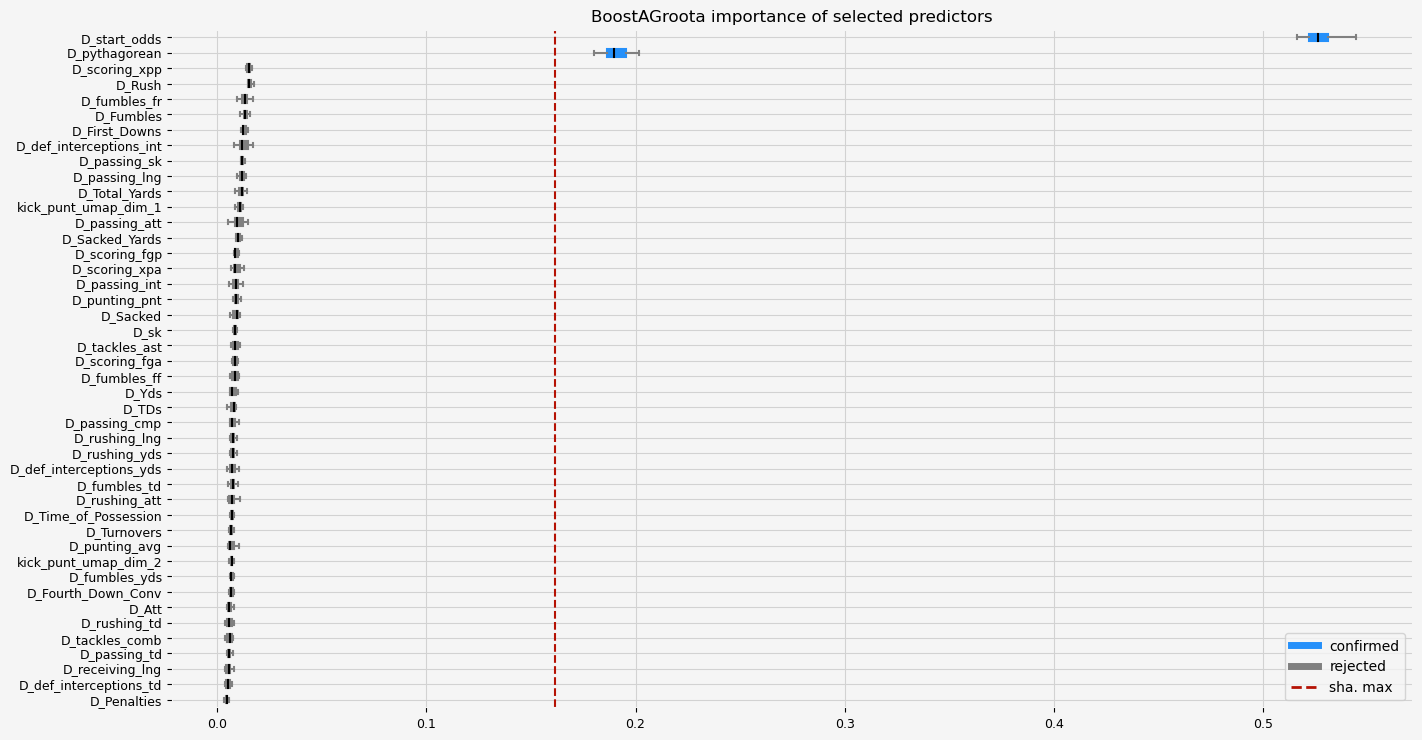

In [12]:
# be sure to use the same but non-fitted estimator
model = LGBMClassifier(random_state=42, verbose=-1)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model,
    cutoff=1,
    iters=10,
    max_rounds=10,
    delta=0.1,
    silent=True,
    importance="fastshap",
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

# Leshy

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	2
Tentative: 	2
Rejected: 	40
All relevant predictors selected in 00:00:00.67
The selected features: ['D_pythagorean' 'D_start_odds']
The agnostic ranking: [26  7 10 29 22 36 17 11  2 29 17  7  9 32  4 41 25 39  5 32 39 41 21 32
 12 17 38 36  2 17 17 23  3 36 23 17  7 13 29 26 17 32  1  1]
The naive ranking: ['D_start_odds', 'D_pythagorean', 'D_Fumbles', 'D_fumbles_fr', 'D_tackles_ast', 'D_passing_cmp', 'D_passing_td', 'D_Fourth_Down_Conv', 'D_Rush', 'D_punting_pnt', 'D_fumbles_yds', 'D_Time_of_Possession', 'D_Yds', 'D_Total_Yards', 'kick_punt_umap_dim_2', 'D_scoring_xpa', 'D_Penalties', 'D_fumbles_td', 'D_punting_avg', 'D_Sacked_Yards', 'D_def_interceptions_int', 'D_def_interceptions_td', 'kick_punt_umap_dim_1', 'D_Att', 'D_First_Downs', 'D_rushing_td', 'D_Turnovers', 'D_TDs', 'D_passing_lng', 'D_sk', 'D_tackles_comb', 'D_def_interceptions_yds', 'D_scoring_fga', 'D_fumbles_ff', 'D_rushing_att', 'D_Sacked',

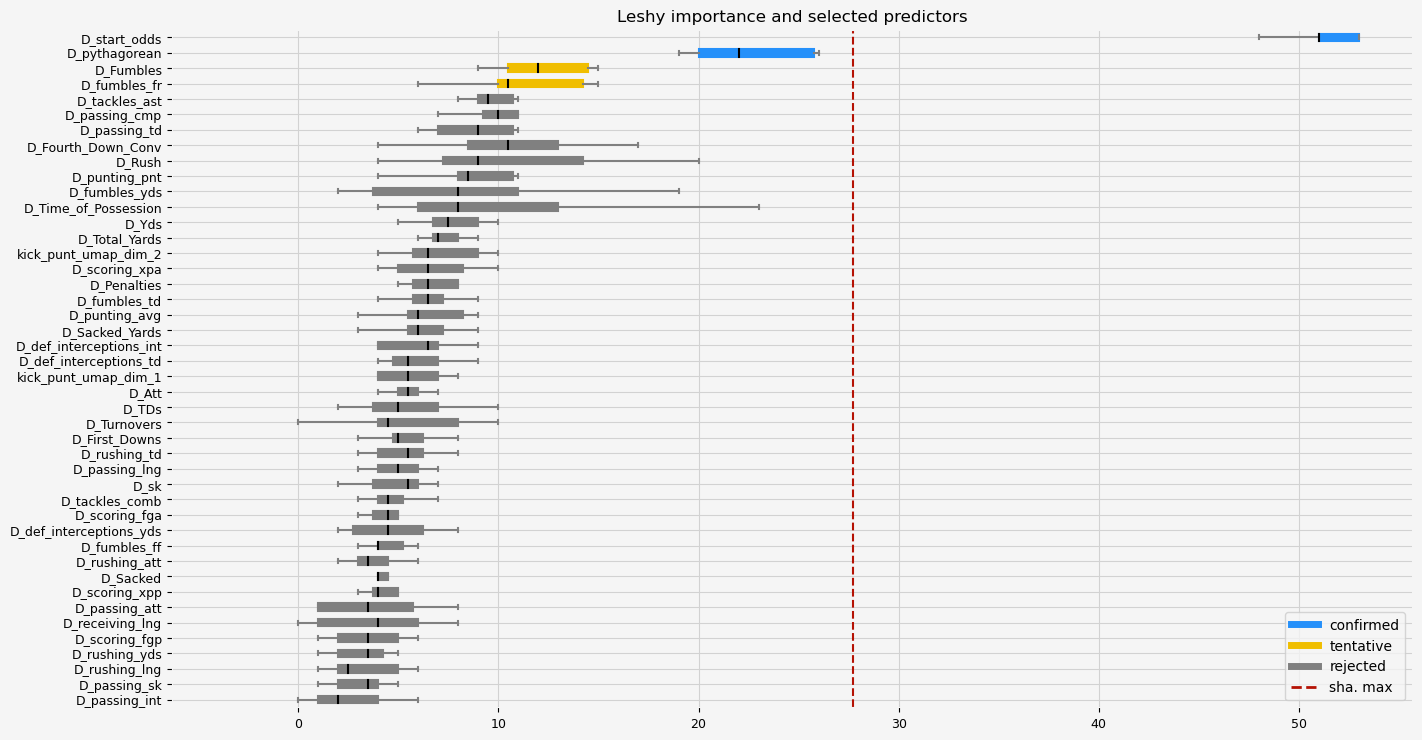

In [13]:
model = LGBMClassifier(random_state=42, verbose=-1)
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## Columns that will be dropped are going to be stored in NFLUtils.drop_cols
We will be targeting variables that have a low ranking for Leshy importance as well as BoostAGroota. In addition to this, we will remove variables that are correlated to others in the most recent y_data profiling run

- **D_datediff** Contains 64% zeros and has a low ranking. This is an clear an easy example of a variable that just contains noise
- **D_Lost** Contains 46.6% zeros and also has appears on the tail end of both Leshy & BoostAGroota reports.
- **D_INT** Contains a high number (42.7%) of zeros as well but also appears on the tail end of Leshy & BoostAGroota reports
- **D_Sk** Highly correlated with D_Sacked, it also appears on the tail end of both reports
- **D_Yd** Is somewhat unique, its highly correlated with a number of other variables (D_Att, D_Yds) and appear on the lower end of both lists

## The following were removed after appearing in bottom 15 records between BoostAGroota and Leshy
- **D_TD**
- **D_Third_Down_conv**
- **D_Cmp**
- **D_tackles_solo**
- **D_Net_Pass_Yards**